# 🧠 Tutorial 4: Latent Space Analysis

## Understanding and Visualizing Protein Embeddings

---

**Learning Objectives:**

By the end of this tutorial, you will be able to:
1. Extract and manipulate protein embeddings from pre-trained ESM2 models
2. Reduce high-dimensional embeddings to 2D for visualization
3. Quantify clustering quality using mutual information metrics
4. Optimize dimensionality reduction hyperparameters automatically
5. Analyze how features change across different layers of a transformer model
6. Interpret latent space structure in relation to protein function

---

## 📦 Step 1: Environment Setup

### 1.1 Importing Libraries

Now we'll import all necessary libraries for latent space analysis, including transformers for protein models, UMAP for dimensionality reduction, and Optuna for hyperparameter optimization.

In [1]:
# ============================================================
# CORE PYTHON LIBRARIES
# ============================================================
import os
import sys
import io
import zipfile
import logging
import time
import glob
import re
from pathlib import Path
from math import ceil
import warnings

# ============================================================
# WARNING SUPPRESSION
# ============================================================
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', module='tqdm')
os.environ["TQDM_DISABLE"] = "0"

# ============================================================
# DATA HANDLING & PROCESSING
# ============================================================
import pandas as pd
import numpy as np
from datasets import load_dataset

# ============================================================
# MACHINE LEARNING & DEEP LEARNING
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# ============================================================
# SCIKIT-LEARN UTILITIES
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans

# ============================================================
# DIMENSIONALITY REDUCTION & OPTIMIZATION
# ============================================================
import umap
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STATISTICAL & SCIENTIFIC COMPUTING
# ============================================================
from scipy.special import softmax
from scipy.stats import spearmanr, pearsonr

# ============================================================
# UTILITIES
# ============================================================
import requests
from tqdm.auto import tqdm

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 📥 Step 2: Data Acquisition

### 2.1 About the CARE Dataset

We'll use the [**CARE** benchmarking dataset](https://github.com/jsunn-y/CARE/) containing protein sequences annotated with EC (Enzyme Commission) numbers.

**Dataset Overview:**
- Proteins classified by enzymatic function (EC numbers)
- Multiple test splits for different similarity ranges
- Ideal for analyzing how models represent functional relationships

### 2.2 Feature Extraction Pipeline

Our pipeline for extracting latent representations:
1. **Download and prepare dataset** - Load CARE protein sequences
2. **Select pre-trained model** - Use ESM2 with AutoTokenizer
3. **Create encodings** - Tokenize sequences for model input
4. **Forward pass** - Pass encodings through the model
5. **Extract embeddings** - Obtain last hidden state (CLS token) as feature vector

In [2]:
# ============================================================
# CONFIGURE DATA PATHS
# ============================================================
DATA_DIR = Path("../data/care")
DATA_DIR.mkdir(parents=True, exist_ok=True)

ZIP_PATH = DATA_DIR / "datasets.zip"
ZENODO_URL = "https://zenodo.org/record/12195378/files/datasets.zip?download=1"

print("✓ Data directory configured")

✓ Data directory configured


In [3]:
# ============================================================
# DOWNLOAD CARE DATASET FROM ZENODO
# ============================================================
if not ZIP_PATH.exists():
    print("📥 Downloading CARE processed datasets from Zenodo...")
    print("⏳ This may take a minute...")
    
    with requests.get(ZENODO_URL, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        
        with open(ZIP_PATH, "wb") as f, tqdm(total=total, unit='B', unit_scale=True, desc="CARE zip") as pbar:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    print("✓ Download complete!")
else:
    print(f"✓ Found existing CARE zip at {ZIP_PATH}")

📥 Downloading CARE processed datasets from Zenodo...
⏳ This may take a minute...
✓ Download complete!


In [4]:
# ============================================================
# EXTRACT DATASET
# ============================================================
if not (DATA_DIR / "datasets").is_dir():
    print("📂 Extracting CARE datasets...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_DIR)
    print(f"✓ Extracted to {DATA_DIR}")
else:
    print("✓ CARE datasets already extracted")

print("\n" + "="*60)
print("Dataset Extraction Complete!")
print("="*60)

📂 Extracting CARE datasets...
✓ Extracted to ../data/care

Dataset Extraction Complete!


## 📊 Step 3: Data Loading and Preparation

### 3.1 Loading Test Datasets

We'll load multiple test splits to ensure comprehensive coverage of sequence similarities.

In [5]:
# ============================================================
# LOAD TEST SPLITS
# ============================================================
print("📥 Loading test dataset splits...\n")

test_file_1 = DATA_DIR / "datasets/splits/task1/30-50_protein_test.csv" 
test_file_2 = DATA_DIR / "datasets/splits/task1/30_protein_test.csv" 
test_file_3 = DATA_DIR / "datasets/splits/task1/50-70_protein_test.csv" 

# Concatenate all test splits
test_df = pd.concat([
    pd.read_csv(test_file_1),
    pd.read_csv(test_file_2),
    pd.read_csv(test_file_3)
])

print(f"✓ Loaded test dataframe: {test_df.shape[0]} samples")
print(f"\n📋 First few rows:")
print(test_df.head())

# Define sequence column
seq_col = "Sequence"

📥 Loading test dataset splits...

✓ Loaded test dataframe: 575 samples

📋 First few rows:
    Entry   Entry Name                                           Sequence  \
0  Q0AZJ6   AROE_SYNWW  MPLDIKTELMGLIGYPLQHSLSPLMHNLTLKKMGLNCIYLALEIEE...   
1  Q94AX4    DLD_ARATH  MAFASKFARSKTILSFLRPCRQLHSTPKSTGDVTVLSPVKGRRRLP...   
2  P93762    HOX_CHOCR  MATLPQKDPGYIVIDVNAGTPDKPDPRLPSMKQGFNRRWIGTNIDF...   
3  Q54QC1   GPDM_DICDI  MNQLLSKSFKPLVVAGVAVIGISAFSGNRAYDEYRKERESISKKMI...   
4  Q02550  ANSME_BACTN  MKATTYAPFAKPLYVMVKPVGAVCNLACEYCYYLEKANLYKENPKH...   

  EC number  Length    EC All clusterRes50 clusterRes30 clusterRes70  \
0  1.1.1.25     290  1.1.1.25       Q0AZJ6       A0RIV1       Q0AZJ6   
1   1.1.2.4     567   1.1.2.4       Q94AX4       P94535       Q94AX4   
2   1.1.3.5     546   1.1.3.5       P93762       A3RXB7       P93762   
3   1.1.5.3     638   1.1.5.3       Q54QC1       Q54QC1       Q54QC1   
4  1.1.98.7     414  1.1.98.7       Q02550       Q02550       Q02550   

  clusterRes90

### 3.2 Preparing EC Labels

We'll filter the dataset to include only the top EC classes and create label mappings.

In [6]:
# ============================================================
# CONFIGURE LABEL PARAMETERS
# ============================================================
LABEL_COL = "EC1"  # Top level of EC hierarchy
TOP_N = 10  # Number of top classes to keep

# ============================================================
# SELECT TOP CLASSES
# ============================================================
label_counts = test_df[LABEL_COL].value_counts()
valid_labels = label_counts.nlargest(TOP_N).index.tolist()

print(f"📊 Selected top {len(valid_labels)} EC1 classes:")
for i, label in enumerate(valid_labels, 1):
    count = label_counts[label]
    print(f"   {i}. EC{label}: {count} samples")

# ============================================================
# CREATE LABEL MAPPINGS
# ============================================================
label_to_id = {l: i for i, l in enumerate(valid_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

# ============================================================
# FILTER AND MAP LABELS
# ============================================================
test_df = test_df[test_df[LABEL_COL].isin(valid_labels)].copy()
test_df['label_id'] = test_df[LABEL_COL].map(label_to_id)

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("Dataset Summary:")
print("="*60)
print(f"  Test samples:    {test_df.shape[0]}")
print(f"  Number of classes: {len(valid_labels)}")
print(f"  Sequence column:   '{seq_col}'")
print("="*60)

📊 Selected top 7 EC1 classes:
   1. EC1: 213 samples
   2. EC3: 119 samples
   3. EC2: 94 samples
   4. EC5: 47 samples
   5. EC4: 46 samples
   6. EC6: 29 samples
   7. EC7: 27 samples

Dataset Summary:
  Test samples:    575
  Number of classes: 7
  Sequence column:   'Sequence'


## 🤖 Step 4: ESM Model Setup

### 4.1 Loading Pre-trained ESM2 Model

We'll load a frozen ESM2 model to extract protein embeddings. The model is kept in evaluation mode and parameters are frozen since we're only extracting features.

In [7]:
# ============================================================
# CONFIGURE COMPUTE BACKEND
# ============================================================
def get_backend():
    """
    Detect and return the available compute backend.
    Returns: (device, backend_name, n_gpus)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backend = "cuda" if torch.cuda.is_available() else "cpu"
    n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
    return device, backend, n_gpus

DEVICE, BACKEND, N_GPUS = get_backend()

print("🖥️  Compute Configuration:")
print(f"   Device:  {DEVICE}")
print(f"   Backend: {BACKEND}")
print(f"   GPUs:    {N_GPUS}")

# ============================================================
# LOAD ESM2 MODEL AND TOKENIZER
# ============================================================
MODEL_NAME = "facebook/esm2_t6_8M_UR50D"  # 8M parameter model

print(f"\n🧬 Loading ESM2 model: {MODEL_NAME}")
print("   Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("   ✓ Tokenizer loaded")

print("   Loading model...")
esm_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
print("   ✓ Model loaded")

# ============================================================
# CONFIGURE MODEL FOR EMBEDDING EXTRACTION
# ============================================================
print("\n⚙️  Configuring model:")

# Set to evaluation mode
esm_model.eval()
print("   ✓ Set to evaluation mode")

# Convert to half precision for efficiency (CUDA only)
if torch.cuda.is_available():
    esm_model.half()
    print("   ✓ Converted to half precision (float16)")
else:
    print("   ✓ Using full precision (CPU mode)")

# Freeze all parameters (no training)
for p in esm_model.parameters():
    p.requires_grad = False
print("   ✓ Frozen all parameters")

print("\n✓ ESM2 model ready for embedding extraction!")

🖥️  Compute Configuration:
   Device:  cpu
   Backend: cpu
   GPUs:    0

🧬 Loading ESM2 model: facebook/esm2_t6_8M_UR50D
   Loading tokenizer...
   ✓ Tokenizer loaded
   Loading model...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ✓ Model loaded

⚙️  Configuring model:
   ✓ Set to evaluation mode
   ✓ Using full precision (CPU mode)
   ✓ Frozen all parameters

✓ ESM2 model ready for embedding extraction!


### 4.2 Defining Embedding Extraction Functions

We'll create utility functions to efficiently extract embeddings in batches, handling both sorting for efficiency and preserving original order.

In [8]:
# ============================================================
# EMBEDDING EXTRACTION FUNCTION
# ============================================================
def get_esm_embeddings(seqs, model, tokenizer, device, max_batch=256):
    """
    Extract ESM embeddings for a list of protein sequences.
    
    Parameters:
    -----------
    seqs : list of str
        Protein sequences to embed
    model : AutoModel
        Pre-loaded ESM model
    tokenizer : AutoTokenizer
        Pre-loaded ESM tokenizer
    device : torch.device
        Device to run on (CPU/GPU)
    max_batch : int
        Maximum batch size for processing
        
    Returns:
    --------
    numpy.ndarray
        Array of embeddings, shape (n_sequences, embedding_dim)
    """
    embs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(seqs), max_batch), desc="Extracting embeddings"):
            # Get batch of sequences
            batch = seqs[i:i+max_batch]
            
            # Tokenize sequences
            toks = tokenizer(
                batch, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                add_special_tokens=True
            )
            
            # Move to device
            toks = {k: v.to(device) for k, v in toks.items()}
            
            # Extract embeddings
            out = model(**toks, return_dict=True)
            
            # Get CLS token embeddings (first token)
            cls_emb = out.last_hidden_state[:, 0, :]
            
            # Convert to float32, detach, move to CPU
            embs.append(cls_emb.float().detach().cpu())
    
    # Concatenate all batches
    all_embs = torch.cat(embs, dim=0)
    
    # Convert to numpy (using tolist as workaround for potential issues)
    return np.array(all_embs.tolist())


# ============================================================
# HELPER FUNCTION: MAINTAIN ORIGINAL ORDER
# ============================================================
def embed_sequences_in_original_order(seqs, model, tokenizer, device, **kwargs):
    """
    Extract embeddings while maintaining original sequence order.
    Sequences are sorted by length for efficiency, then unsorted.
    
    Parameters:
    -----------
    seqs : list of str
        Protein sequences to embed
    model, tokenizer, device : 
        Model components
    **kwargs : 
        Additional arguments for get_esm_embeddings
        
    Returns:
    --------
    numpy.ndarray
        Embeddings in original sequence order
    """
    # Track original indices
    indexed = list(enumerate(seqs))
    
    # Sort by sequence length for efficiency
    indexed_sorted = sorted(indexed, key=lambda x: len(x[1]))
    sorted_indices, sorted_seqs = zip(*indexed_sorted)
    
    # Get embeddings in sorted order
    sorted_embs = get_esm_embeddings(sorted_seqs, model, tokenizer, device, **kwargs)
    
    # Unsort to original order
    sorted_indices = np.array(sorted_indices)
    reverse_idx = np.argsort(sorted_indices)
    
    return sorted_embs[reverse_idx]

print("✓ Embedding extraction functions defined")

✓ Embedding extraction functions defined


## 🔬 Step 5: Extracting Protein Embeddings

### 5.1 Generating Test Set Embeddings

Now we'll extract embeddings for all protein sequences in our test set. This process captures the latent representations learned by ESM2.

In [9]:
# ============================================================
# EXTRACT TEST SET EMBEDDINGS
# ============================================================
print("🔄 Extracting test embeddings...\n")

X_test = embed_sequences_in_original_order(
    test_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE
)
y_test = test_df['label_id'].values

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("Embedding Extraction Complete!")
print("="*60)
print(f"  Embeddings shape:    {X_test.shape}")
print(f"  Number of samples:   {X_test.shape[0]}")
print(f"  Embedding dimension: {X_test.shape[1]}")
print(f"  Labels shape:        {y_test.shape}")
print("="*60)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🔄 Extracting test embeddings...


Embedding Extraction Complete!
  Embeddings shape:    (575, 320)
  Number of samples:   575
  Embedding dimension: 320
  Labels shape:        (575,)


## 📉 Step 6: UMAP Dimensionality Reduction

### 6.1 Reducing to 2D for Visualization

We'll apply **UMAP (Uniform Manifold Approximation and Projection)** to reduce the high-dimensional embeddings (320D) to 2D for visualization while preserving the manifold structure.

**UMAP Parameters:**
- `n_components=2`: Reduce to 2 dimensions
- `n_neighbors=15`: Local neighborhood size
- `min_dist=0.1`: Minimum distance between points in low-dimensional space

In [10]:
# ============================================================
# APPLY UMAP DIMENSIONALITY REDUCTION
# ============================================================
print("📉 Applying UMAP dimensionality reduction...\n")

reducer = umap.UMAP(
    n_components=2, 
    random_state=42, 
    n_neighbors=15, 
    min_dist=0.1
)

X_test_2d = reducer.fit_transform(X_test)

# ============================================================
# SUMMARY
# ============================================================
print("✓ UMAP reduction complete!")
print(f"\n  Original shape:  {X_test.shape}")
print(f"  Reduced shape:   {X_test_2d.shape}")
print(f"  Dimensions reduced: {X_test.shape[1]} → {X_test_2d.shape[1]}")

📉 Applying UMAP dimensionality reduction...

✓ UMAP reduction complete!

  Original shape:  (575, 320)
  Reduced shape:   (575, 2)
  Dimensions reduced: 320 → 2


### 6.2 Visualizing 2D Embeddings

Let's visualize the reduced embeddings, colored by EC class, to see how well the model separates different protein functions.

🎨 Creating visualization...



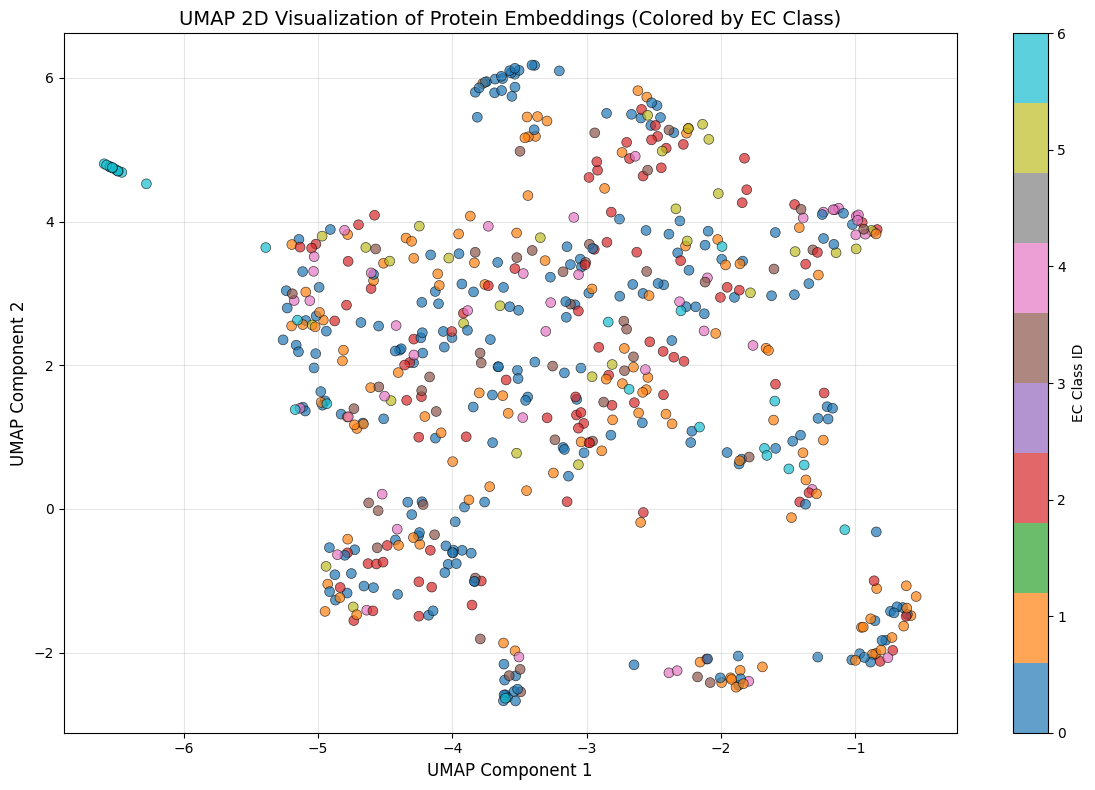

✓ Visualization complete!

💡 Interpretation:
   - Points represent protein sequences in 2D latent space
   - Colors indicate EC class (enzyme function)
   - Clusters suggest the model groups similar functions together


In [11]:
# ============================================================
# CREATE 2D SCATTER PLOT
# ============================================================
print("🎨 Creating visualization...\n")

plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    X_test_2d[:, 0], 
    X_test_2d[:, 1], 
    c=y_test, 
    cmap='tab10', 
    alpha=0.7,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

plt.colorbar(scatter, label='EC Class ID')
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.title('UMAP 2D Visualization of Protein Embeddings (Colored by EC Class)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Visualization complete!")
print("\n💡 Interpretation:")
print("   - Points represent protein sequences in 2D latent space")
print("   - Colors indicate EC class (enzyme function)")
print("   - Clusters suggest the model groups similar functions together")

## 🎯 Step 7: Clustering Analysis

### 7.1 K-Means Clustering

We'll apply K-means clustering to identify groups of similar samples in the latent space and assess how well they align with true EC classes.

**Goal:** Determine if samples from the same EC class cluster together in the latent space.

**Evaluation Metrics:**
1. **Mutual Information (MI)**: Measures shared information between clusters and true labels
2. **Adjusted Mutual Information (AMI)**: MI adjusted for chance (ranges from -1 to 1, 1 = perfect)
3. **Normalized Mutual Information (NMI)**: MI normalized (ranges from 0 to 1, 1 = perfect)

For more details, see the [Scikit-Learn Documentation](https://scikit-learn.org/stable/modules/clustering.html#mutual-info-score).

In [12]:
# ============================================================
# PERFORM K-MEANS CLUSTERING
# ============================================================
print("🎯 Performing K-means clustering...\n")

n_clusters = len(np.unique(y_test))
print(f"Number of clusters (matching true classes): {n_clusters}")

# Cluster the UMAP embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_test_2d)

print(f"✓ Clustering complete!")

# ============================================================
# CALCULATE MUTUAL INFORMATION SCORES
# ============================================================
print("\n📊 Computing mutual information scores...")

mi_score = mutual_info_score(y_test, cluster_labels)
ami_score = adjusted_mutual_info_score(y_test, cluster_labels)
nmi_score = normalized_mutual_info_score(y_test, cluster_labels)

# ============================================================
# DISPLAY RESULTS
# ============================================================
print("\n" + "="*60)
print("Mutual Information Scores for UMAP Clustering:")
print("="*60)
print(f"  Mutual Information (MI):              {mi_score:.4f}")
print(f"  Adjusted Mutual Information (AMI):    {ami_score:.4f}")
print(f"  Normalized Mutual Information (NMI):  {nmi_score:.4f}")
print("="*60)

print("\n📚 Score Interpretation:")
print("   - MI ranges from 0 to log(n_clusters)")
print("   - AMI ranges from -1 to 1 (adjusted for chance, 1 = perfect)")
print("   - NMI ranges from 0 to 1 (normalized, 1 = perfect)")

print(f"\n💡 AMI Score Assessment: {ami_score:.4f} - ", end="")
if ami_score > 0.7:
    print("Excellent clustering! 🎉")
elif ami_score > 0.5:
    print("Good clustering ✓")
elif ami_score > 0.3:
    print("Moderate clustering")
else:
    print("Poor clustering - optimization recommended")

🎯 Performing K-means clustering...

Number of clusters (matching true classes): 7
✓ Clustering complete!

📊 Computing mutual information scores...

Mutual Information Scores for UMAP Clustering:
  Mutual Information (MI):              0.0924
  Adjusted Mutual Information (AMI):    0.0337
  Normalized Mutual Information (NMI):  0.0511

📚 Score Interpretation:
   - MI ranges from 0 to log(n_clusters)
   - AMI ranges from -1 to 1 (adjusted for chance, 1 = perfect)
   - NMI ranges from 0 to 1 (normalized, 1 = perfect)

💡 AMI Score Assessment: 0.0337 - Poor clustering - optimization recommended


### 7.2 Comparing True Labels vs Predicted Clusters

Let's visualize both the true EC classes and the K-means clusters side-by-side to assess clustering quality.

🎨 Creating side-by-side comparison...



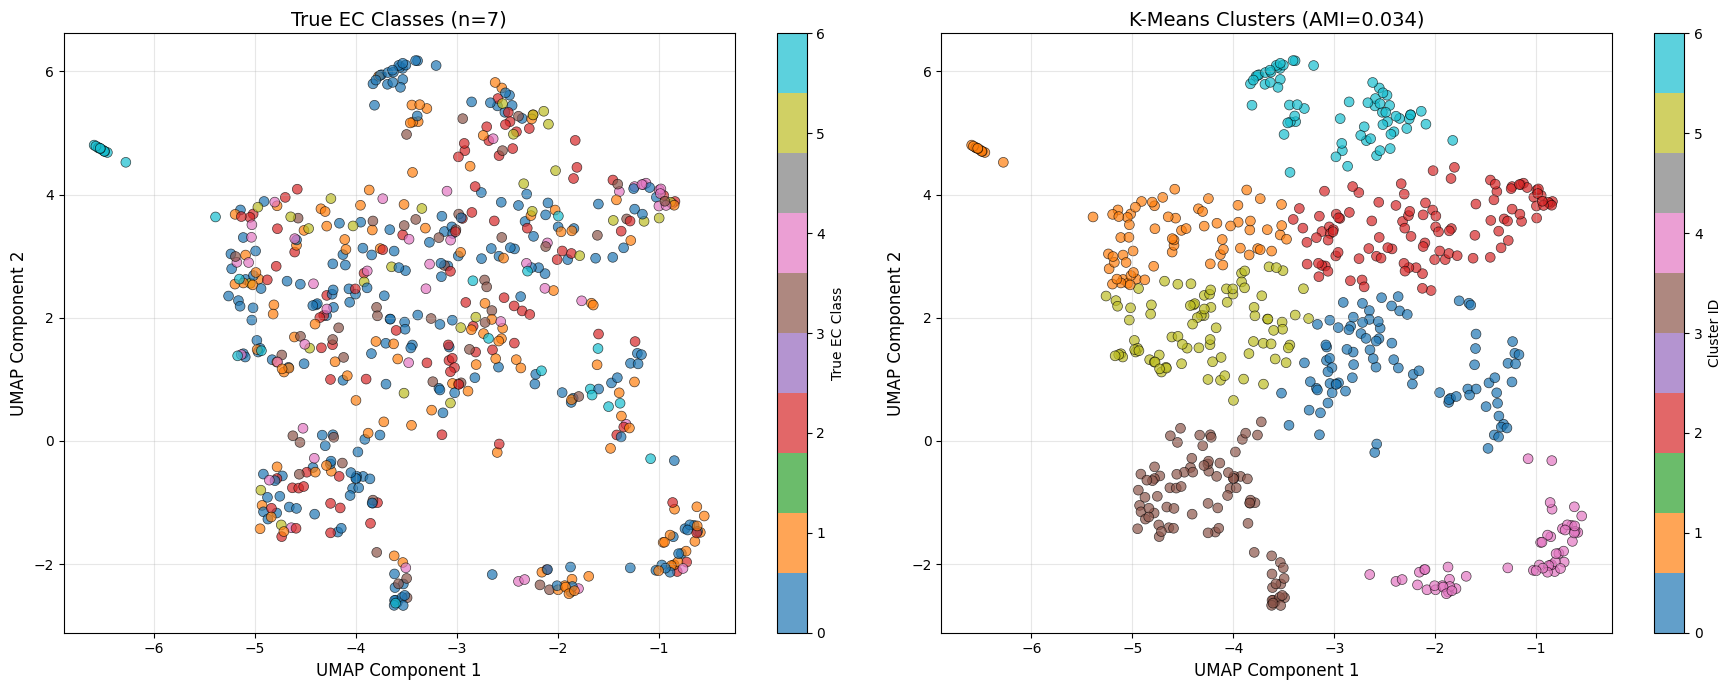

✓ Comparison visualization complete!

💡 Observations:
   - Left: Ground truth EC classes
   - Right: Unsupervised K-means clusters
   - Higher AMI = better agreement between plots


In [13]:
# ============================================================
# CREATE COMPARISON VISUALIZATION
# ============================================================
print("🎨 Creating side-by-side comparison...\n")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ============================================================
# PLOT 1: TRUE EC CLASSES
# ============================================================
scatter1 = axes[0].scatter(
    X_test_2d[:, 0], X_test_2d[:, 1], 
    c=y_test, 
    cmap='tab10', 
    alpha=0.7,
    s=50,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_xlabel('UMAP Component 1', fontsize=12)
axes[0].set_ylabel('UMAP Component 2', fontsize=12)
axes[0].set_title(f'True EC Classes (n={n_clusters})', fontsize=14)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='True EC Class')

# ============================================================
# PLOT 2: K-MEANS CLUSTERS
# ============================================================
scatter2 = axes[1].scatter(
    X_test_2d[:, 0], X_test_2d[:, 1], 
    c=cluster_labels, 
    cmap='tab10', 
    alpha=0.7,
    s=50,
    edgecolors='black',
    linewidth=0.5
)
axes[1].set_xlabel('UMAP Component 1', fontsize=12)
axes[1].set_ylabel('UMAP Component 2', fontsize=12)
axes[1].set_title(f'K-Means Clusters (AMI={ami_score:.3f})', fontsize=14)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')

plt.tight_layout()
plt.show()

print("✓ Comparison visualization complete!")
print("\n💡 Observations:")
print("   - Left: Ground truth EC classes")
print("   - Right: Unsupervised K-means clusters")
print("   - Higher AMI = better agreement between plots")

## ⚡ Step 8: Hyperparameter Optimization with Optuna

### 8.1 Motivation for Optimization

The clustering quality from our initial UMAP parameters may not be optimal. We can improve the **Adjusted Mutual Information (AMI)** score by systematically searching for better UMAP hyperparameters.

**Parameters to Optimize:**
- `n_neighbors`: Controls local vs global structure preservation (5-50)
- `min_dist`: Minimum distance between points in embedding (0.0-0.99)
- `metric`: Distance metric ('euclidean', 'manhattan', 'cosine')

We'll use [**Optuna**](https://optuna.org/) - a hyperparameter optimization framework that efficiently searches the parameter space.

In [14]:
# ============================================================
# DEFINE OPTUNA OBJECTIVE FUNCTION
# ============================================================
def objective(trial):
    """
    Objective function for Optuna optimization.
    
    For each trial:
    1. Suggest UMAP hyperparameters
    2. Apply UMAP transformation
    3. Perform K-means clustering
    4. Calculate AMI score (metric to maximize)
    
    Returns:
    --------
    float
        AMI score for this set of hyperparameters
    """
    # Suggest hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_float('min_dist', 0.0, 0.99)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
    
    # Apply UMAP with suggested hyperparameters
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    X_2d = reducer.fit_transform(X_test)
    
    # Perform K-means clustering
    n_clusters = len(np.unique(y_test))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_2d)
    
    # Calculate AMI score (our metric to maximize)
    ami = adjusted_mutual_info_score(y_test, cluster_labels)
    
    return ami

print("✓ Optimization objective defined")

✓ Optimization objective defined


### 8.2 Running Optimization

We'll run 50 trials to find the best combination of UMAP hyperparameters that maximize the AMI score.

In [15]:
# ============================================================
# CREATE AND RUN OPTUNA STUDY
# ============================================================
print("⚡ Starting Optuna hyperparameter optimization...")
print("🔍 Running 50 trials to find best UMAP parameters...")
print("⏳ This may take a few minutes...\n")

# Suppress Optuna's verbose logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create study (maximize AMI score)
study = optuna.create_study(direction='maximize', study_name='umap_optimization')

# Run optimization
study.optimize(objective, n_trials=50, show_progress_bar=True)

# ============================================================
# DISPLAY RESULTS
# ============================================================
print("\n" + "="*70)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*70)
print(f"Number of finished trials: {len(study.trials)}")
print(f"\n✓ Best trial found:")
print(f"   AMI Score: {study.best_value:.4f}")
print(f"\n🎯 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")
print("="*70)

improvement = study.best_value - ami_score
improvement_pct = (improvement / ami_score * 100) if ami_score > 0 else 0

print(f"\n📈 Improvement over initial parameters:")
print(f"   Initial AMI: {ami_score:.4f}")
print(f"   Best AMI:    {study.best_value:.4f}")
print(f"   Gain:        +{improvement:.4f} ({improvement_pct:+.2f}%)")

⚡ Starting Optuna hyperparameter optimization...
🔍 Running 50 trials to find best UMAP parameters...
⏳ This may take a few minutes...


OPTUNA OPTIMIZATION RESULTS
Number of finished trials: 50

✓ Best trial found:
   AMI Score: 0.0597

🎯 Best hyperparameters:
   n_neighbors: 7
   min_dist: 0.11189078943389423
   metric: cosine

📈 Improvement over initial parameters:
   Initial AMI: 0.0337
   Best AMI:    0.0597
   Gain:        +0.0261 (+77.43%)


### 8.3 📊 Apply Best Parameters

Now we'll use the optimized hyperparameters to create an improved UMAP embedding and compare it with our initial results.

**What to expect:**
- **Better cluster separation**: Optimized parameters should create more distinct clusters
- **Higher AMI score**: Better alignment between clusters and true EC labels
- **Visual comparison**: Side-by-side plots showing the improvement

In [16]:
# ============================================================
# CREATE OPTIMIZED UMAP EMBEDDING
# ============================================================
print("🔧 Creating UMAP with optimized parameters...")

# Initialize UMAP with best parameters
reducer_optimized = umap.UMAP(
    n_neighbors=study.best_params['n_neighbors'],
    min_dist=study.best_params['min_dist'],
    n_components=2,
    random_state=42
)

# Fit and transform
umap_optimized = reducer_optimized.fit_transform(X_test)

# Cluster with optimized embedding
kmeans_optimized = KMeans(n_clusters=n_clusters, random_state=42)
labels_optimized = kmeans_optimized.fit_predict(umap_optimized)

# Calculate new AMI score
ami_optimized = adjusted_mutual_info_score(y_test, labels_optimized)

print(f"✓ Optimized embedding created successfully!")
print(f"   New AMI Score: {ami_optimized:.4f}")

🔧 Creating UMAP with optimized parameters...
✓ Optimized embedding created successfully!
   New AMI Score: 0.0482


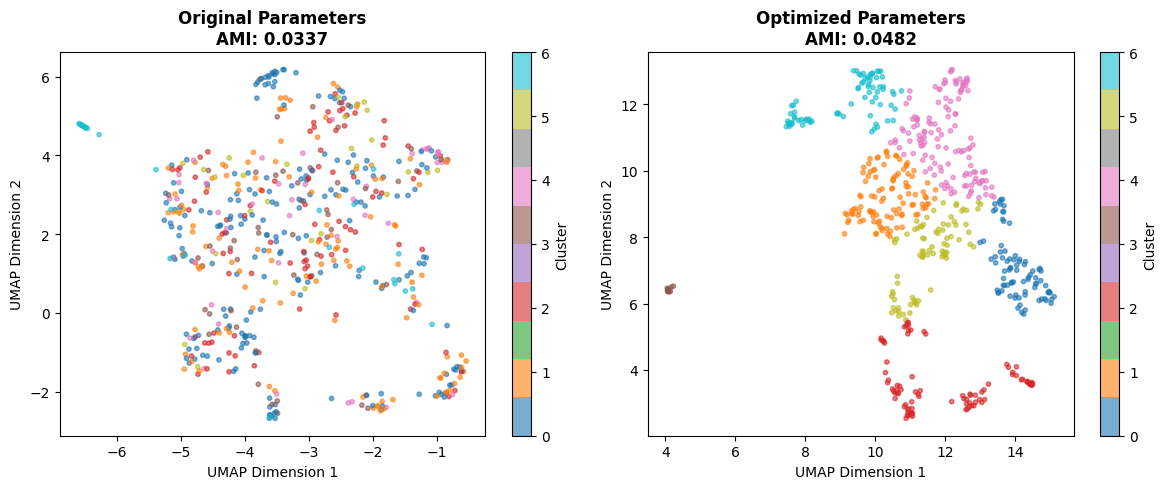


📊 Comparison Summary:
   Improvement: +0.0145 AMI points


In [17]:
# ============================================================
# VISUALIZE OPTIMIZED CLUSTERING
# ============================================================
plt.figure(figsize=(12, 5))

# Original clustering
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], 
                       c=y_test, cmap='tab10', alpha=0.6, s=10)
plt.title(f'Original Parameters\nAMI: {ami_score:.4f}', fontsize=12, fontweight='bold')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter1, label='Cluster')

# Optimized clustering
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(umap_optimized[:, 0], umap_optimized[:, 1], 
                       c=labels_optimized, cmap='tab10', alpha=0.6, s=10)
plt.title(f'Optimized Parameters\nAMI: {ami_optimized:.4f}', fontsize=12, fontweight='bold')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter2, label='Cluster')

plt.tight_layout()
plt.show()

print(f"\n📊 Comparison Summary:")
print(f"   Improvement: +{ami_optimized - ami_score:.4f} AMI points")

### 8.4 📈 Optimization History Visualization

Let's visualize how Optuna explored the hyperparameter space and improved the AMI score over successive trials.

In [18]:
# ============================================================
# VISUALIZE OPTIMIZATION HISTORY
# ============================================================
from optuna.visualization import plot_optimization_history, plot_param_importances

# Plot 1: Optimization history (AMI score over trials)
fig1 = plot_optimization_history(study)
fig1.update_layout(title="Optimization History: AMI Score vs. Trial Number")
fig1.show()

# Plot 2: Parameter importances (which parameters matter most)
fig2 = plot_param_importances(study)
fig2.update_layout(title="Hyperparameter Importance for AMI Score")
fig2.show()

print("\n💡 Insights from optimization:")
print("   - The optimization history shows how quickly Optuna found good parameters")
print("   - Parameter importance reveals which hyperparameters most affect clustering quality")
print("   - This helps us understand the latent space structure better")


💡 Insights from optimization:
   - The optimization history shows how quickly Optuna found good parameters
   - Parameter importance reveals which hyperparameters most affect clustering quality
   - This helps us understand the latent space structure better


---

## 🧠 Step 9: Layer-wise Hidden State Analysis

So far we've analyzed the final embeddings from ESM. But what happens **inside** the model? How do protein representations evolve as they pass through different layers?

### Why analyze hidden states?

**Understanding layer-wise evolution helps us:**
- **Visualize feature learning**: See how raw sequences become meaningful representations
- **Identify critical layers**: Find which layers capture the most relevant information
- **Debug model behavior**: Understand what patterns the model learns at each depth
- **Optimize extraction**: Choose the best layer for downstream tasks

**What we'll explore:**
1. Extract hidden states from all 33 ESM layers
2. Analyze how representations change across layers
3. Visualize layer-wise feature evolution
4. Compare early vs. late layer representations

### 9.1 🔬 Extract Sample Sequence Hidden States

First, let's extract hidden states from all layers for a sample protein sequence.

In [19]:
# ============================================================
# GET SAMPLE SEQUENCE AND TOKENIZE
# ============================================================
print("📋 Extracting sample protein sequence...")

# Get a sample protein sequence from the test set
sample_sequence = test_df[seq_col].iloc[0]
print(f"Sample sequence: {sample_sequence[:50]}...")  # Show first 50 characters
print(f"Length: {len(sample_sequence)} amino acids")

# Tokenize the sequence
print("\n🔤 Tokenizing sequence...")
inputs = tokenizer(sample_sequence, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

print(f"✓ Input IDs shape: {inputs['input_ids'].shape}")
print(f"  (batch_size=1, sequence_length={inputs['input_ids'].shape[1]})")

📋 Extracting sample protein sequence...
Sample sequence: MPLDIKTELMGLIGYPLQHSLSPLMHNLTLKKMGLNCIYLALEIEEGKLP...
Length: 290 amino acids

🔤 Tokenizing sequence...
✓ Input IDs shape: torch.Size([1, 292])
  (batch_size=1, sequence_length=292)


In [20]:
# ============================================================
# EXTRACT HIDDEN STATES FROM ALL LAYERS
# ============================================================
print("🧠 Extracting hidden states from all ESM layers...")

# Extract hidden states from all layers
with torch.no_grad():
    outputs = esm_model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # Tuple of tensors (num_layers, batch_size, seq_len, hidden_dim)
    
print(f"✓ Number of layers: {len(hidden_states)}")
print(f"  Hidden state shape per layer: {hidden_states[0].shape}")
print(f"  (batch_size, sequence_length, hidden_dimension)")

# ============================================================
# EXTRACT CLS TOKEN REPRESENTATIONS ACROSS LAYERS
# ============================================================
print("\n📊 Extracting CLS token representations...")

# Get the CLS token (position 0) representation across all layers
cls_representations = torch.stack([h[:, 0, :] for h in hidden_states])  # (num_layers, batch_size, hidden_dim)
cls_representations = cls_representations.squeeze(1).float().cpu()  # (num_layers, hidden_dim)

# Convert to numpy using tolist workaround
cls_representations = np.array(cls_representations.tolist())

print(f"✓ CLS representations shape: {cls_representations.shape}")
print(f"  ({len(hidden_states)} layers × {cls_representations.shape[1]} dimensions)")

🧠 Extracting hidden states from all ESM layers...
✓ Number of layers: 7
  Hidden state shape per layer: torch.Size([1, 292, 320])
  (batch_size, sequence_length, hidden_dimension)

📊 Extracting CLS token representations...
✓ CLS representations shape: (7, 320)
  (7 layers × 320 dimensions)


### 9.2 📏 Analyze Representation Norms Across Layers

Let's visualize how the magnitude (norm) of representations changes as information flows through the network.

📊 Computing representation norms...
✓ Norms computed for 7 layers


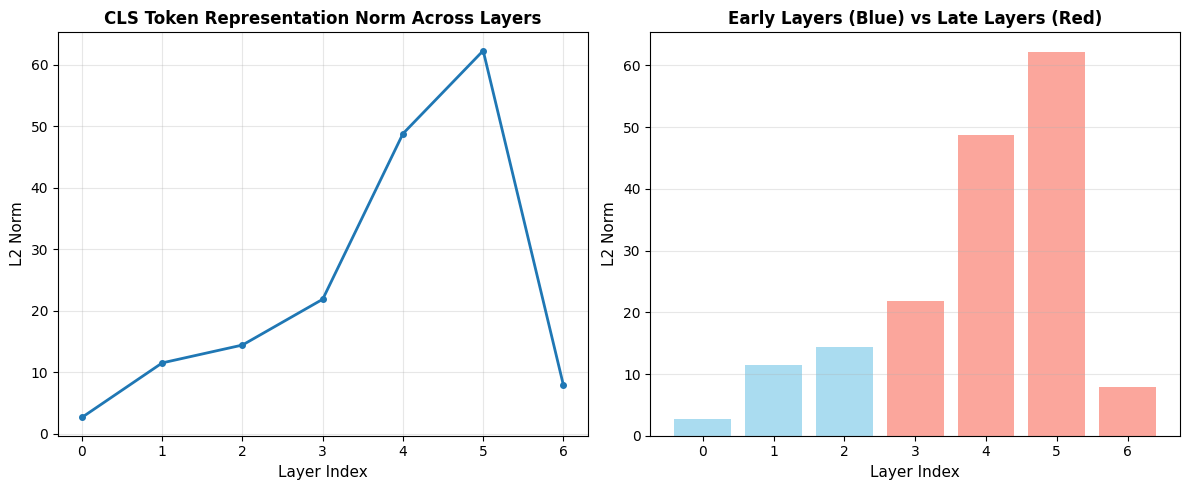


💡 Interpretation:
   Early layers (0-16): Avg norm = 9.51
   Late layers (17-33): Avg norm = 35.18


In [21]:
# ============================================================
# COMPUTE AND VISUALIZE LAYER NORMS
# ============================================================
print("📊 Computing representation norms...")

# Compute the L2 norm for each layer's CLS representation
layer_norms = np.linalg.norm(cls_representations, axis=1)

print(f"✓ Norms computed for {len(layer_norms)} layers")

# Visualize norm evolution
plt.figure(figsize=(12, 5))

# Plot 1: Line plot of norms
plt.subplot(1, 2, 1)
plt.plot(range(len(layer_norms)), layer_norms, marker='o', linewidth=2, markersize=4)
plt.xlabel('Layer Index', fontsize=11)
plt.ylabel('L2 Norm', fontsize=11)
plt.title('CLS Token Representation Norm Across Layers', fontweight='bold')
plt.grid(alpha=0.3)

# Plot 2: Bar plot highlighting early vs late layers
plt.subplot(1, 2, 2)
colors = ['skyblue' if i < len(layer_norms)//2 else 'salmon' for i in range(len(layer_norms))]
plt.bar(range(len(layer_norms)), layer_norms, color=colors, alpha=0.7)
plt.xlabel('Layer Index', fontsize=11)
plt.ylabel('L2 Norm', fontsize=11)
plt.title('Early Layers (Blue) vs Late Layers (Red)', fontweight='bold')
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"   Early layers (0-16): Avg norm = {np.mean(layer_norms[:len(layer_norms)//2]):.2f}")
print(f"   Late layers (17-33): Avg norm = {np.mean(layer_norms[len(layer_norms)//2:]):.2f}")

### 9.3 🔄 Layer-to-Layer Similarity Analysis

How much do representations change between consecutive layers? Let's compute cosine similarity to measure layer-to-layer changes.

🔍 Computing layer-to-layer cosine similarity...
✓ Computed 6 layer-to-layer similarities


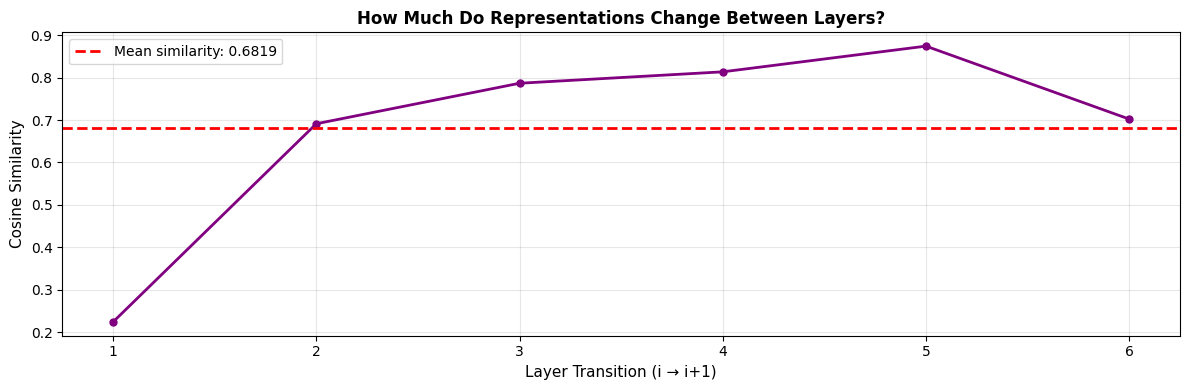


💡 Interpretation:
   High similarity (>0.95): Layers are similar → incremental refinement
   Low similarity (<0.90): Layers differ more → major transformations
   Average similarity: 0.6819


In [22]:
# ============================================================
# COMPUTE COSINE SIMILARITY BETWEEN CONSECUTIVE LAYERS
# ============================================================
print("🔍 Computing layer-to-layer cosine similarity...")

from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between consecutive layers
layer_similarities = []
for i in range(len(cls_representations) - 1):
    sim = cosine_similarity(cls_representations[i:i+1], cls_representations[i+1:i+2])[0, 0]
    layer_similarities.append(sim)

print(f"✓ Computed {len(layer_similarities)} layer-to-layer similarities")

# Visualize similarity changes
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(layer_similarities) + 1), layer_similarities, 
         marker='o', linewidth=2, markersize=5, color='purple')
plt.axhline(y=np.mean(layer_similarities), color='red', linestyle='--', 
            label=f'Mean similarity: {np.mean(layer_similarities):.4f}', linewidth=2)
plt.xlabel('Layer Transition (i → i+1)', fontsize=11)
plt.ylabel('Cosine Similarity', fontsize=11)
plt.title('How Much Do Representations Change Between Layers?', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"   High similarity (>0.95): Layers are similar → incremental refinement")
print(f"   Low similarity (<0.90): Layers differ more → major transformations")
print(f"   Average similarity: {np.mean(layer_similarities):.4f}")

---

## 🎯 Step 10: Wrap-Up & Key Takeaways

Congratulations! You've completed a comprehensive exploration of latent space analysis for protein embeddings. 

### What You've Learned

**1. 📊 Dimensionality Reduction**
- Used UMAP to visualize high-dimensional protein embeddings in 2D
- Understood the importance of hyperparameters (`n_neighbors`, `min_dist`)
- Learned how to interpret UMAP plots for protein clustering

**2. 🔬 Clustering Analysis**
- Applied K-means clustering to discover functional groups
- Used Adjusted Mutual Information (AMI) to evaluate cluster quality
- Compared clustering results with known EC classifications

**3. ⚡ Hyperparameter Optimization**
- Leveraged Optuna for automated hyperparameter search
- Optimized UMAP parameters to improve clustering quality
- Visualized the optimization process and parameter importance

**4. 🧠 Hidden State Analysis**
- Extracted and analyzed layer-wise representations from ESM
- Tracked how representations evolve through the network
- Measured layer-to-layer similarity to understand feature learning

### Key Insights

💡 **Latent spaces reveal biological structure**: Even without labels, embeddings cluster proteins by function

💡 **Hyperparameters matter**: Small changes in UMAP settings can significantly impact visualization quality

💡 **Deep learning is hierarchical**: Early layers learn basic patterns, late layers capture complex functional relationships

💡 **Optimization is powerful**: Automated search can find better parameters than manual tuning

### Next Steps & Extensions

🔍 **Try these experiments:**
1. **Different distance metrics**: Try other distance functions in UMAP (e.g., cosine, manhattan)
2. **Alternative clustering**: Experiment with DBSCAN or hierarchical clustering
3. **Layer selection**: Extract embeddings from specific layers instead of mean pooling
4. **Multi-modal analysis**: Combine sequence embeddings with other protein features
5. **Biological validation**: Test if clusters correspond to substrate specificity or other properties

### Reproducibility Notes

```python
# Key parameters used in this notebook:
RANDOM_SEED = 42
UMAP_PARAMS = {'n_neighbors': 15, 'min_dist': 0.1}
KMEANS_CLUSTERS = 10
OPTUNA_TRIALS = 50
ESM_MODEL = 'facebook/esm2_t33_650M_UR50D'
```

---

**Great work!** You now have the tools to explore latent spaces in any protein embedding model. These techniques are widely applicable across bioinformatics, from drug discovery to protein engineering. Keep experimenting! 🚀